In [19]:
%matplotlib widget
from reconstruction import reconstruct_vols_from_imgs
from i_o import Paths, VolumeReader,get_stimulus, parse_combinations
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib

from daio.h5 import lazyh5
from video import create_projection_image, recording_to_overlay_preview, showvid, get_lenses, array3d_to_video
from widgets import get_mask_widget, ortho_views_widget, play_video_widget
cmap = "gray"

In [3]:
pn_psf = r"Y:/hpc/r/lfm2025/psfs"
pn_psfs = r"~/hpc-rw/lfm/psfs" 
includes = [''] 
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_psfs, '*'))), reverse=True) if os.path.exists(os.path.join(pn_psfs, rec, 'psf.h5'))] 
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])] 
print('\n'.join(recs))

20250819_1203_PSF_LB_25x_5fps
20250813_1750_PSF_LB_25x_3fps
20250730_1431_PSF_LB_redFB_noap_25x
20250701_1216_PSF_LB_noap_old
20250701_1216_PSF_LB_noap_1
20250610_1636_PSF_LB_30k_wo_coverslip_1
20250530_1330_PSF_LB_redFB_1-30K_dim_isolated
20250509_1646_PSF_LB_redFB_1_30K_wo_coverslip_1
20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3


In [4]:
pn_bg = r"~/hpc-rw/lfm/bg"
for file in sorted(pathlib.Path(os.path.expanduser(pn_bg)).iterdir()):
    if file.is_file() and file.suffix == '.npy':
        print(file.name)

20250602_1749_LB_bg_100s.npy
20250602_1749_LB_bg_100s_100laser_2fps.npy
20250602_1753_LB_bg_200s.npy
20250602_1753_LB_bg_200s_100laser_2fps.npy
20250610_1904_80laser_5fps.npy
20250610_1904_LB_30k_wo_coverslip_1_bg.npy
20250611_1508_LB_40fps_100laser_bg.npy
20250611_1508_LB_80fps_100laser_bg.npy
20250701_1649_LB_bg_80fps.npy
20250701_1651_LB_bg_40fps.npy
20250701_1654_LB_bg_2fps.npy
20250729_1146_LB_DC1_5dpf_backfill_1_bg.npy
20250729_1200_LB_DC1_5dpf_backfill_bg_wap_40fps.npy
20250729_1233_LB_DC4_5dpf_backfill_bg_2fps.npy
20250729_1600_LB_DC8_5dpf_backfill_bg_2fps.npy
20250729_1605_LB_DC8_5dpf_backfill_bg_2.npy
20250730_1553_LB_25x_5fps_bg.npy
20250731_1654_LB_redFB_25x_2_bg.npy
20250813_1721_psf_2fps_bg.npy
20250813_1729_psf_4fps_bg.npy
20250813_1730_psf_3fps_bg.npy
20250814_1645_LB_80fps_bg.npy
20250814_1646_LB_40fps_bg.npy
20250815_1937_LBKK_backfill_25x_zf5499i_1_10fps_bg.npy
20250815_1938_LBKK_backfill_25x_zf5499i_1_20fps_bg.npy
20250815_1938_LBKK_backfill_25x_zf5499i_1_40fps_bg.n

In [5]:
# pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_rec = r"~/hpc-r/lfm2025/recordings"
includes = ['']
excludes = ["bg"]

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_rec, '*'))), reverse=True) if os.path.exists(os.path.join(pn_rec, rec, 'data.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250902_2047_LB_ZF552_f4_stim2_1
20250902_2042_LB_ZF552_f3_stim2_1
20250902_1940_LB_ZF552_f2_stim2_3
20250902_1756_LB_ZF552_f1_stim2_3
20250828_1718_LB_zf552_para_f1_4
20250828_1717_LB_zf552_para_f1_4
20250828_1713_LB_zf552_para_f1_3
20250828_1708_LB_zf552_para_f1_2
20250815_1935_LBKK_backfill_25x_zf5499i_1_10fps
20250815_1933_LBKK_backfill_25x_zf5499i_1_40fps
20250815_1931_LBKK_backfill_25x_zf5499i_1_20fps
20250814_1548_LB_zf552_25x_f6_80fps_1
20250814_1541_LB_zf552_25x_f6_80fps_1
20250814_1540_LB_zf552_25x_f6_40fps_1
20250814_1527_LB_zf552_25x_f5_80fps_2
20250814_1525_LB_zf552_25x_f5_40fps_1
20250814_1522_LB_zf552_25x_f5_80fps_1
20250814_1511_LB_zf552_25x_f4_80fps_2
20250814_1505_LB_zf552_25x_f4_80fps_1
20250814_1504_LB_zf552_25x_f4_40fps_1
20250814_1441_LB_zf552_25x_f3_40fps_1
20250814_1436_LB_zf552_25x_f3_80fps_1
20250814_1420_LB_zf552_25x_f2_80fps_2
20250814_1417_LB_zf552_25x_f2_80fps_1
20250814_1410_LB_zf552_25x_f2_40fps_1
20250814_1341_LB_zf552_25x_f1_80fps_1
20250814_1339_LB_z

In [46]:
import i_o
importlib.reload(i_o)
from i_o import Paths

pn_psfs = r"~/hpc-rw/lfm/psfs"
# pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250902_1756_LB_ZF552_f1_stim2_3"
psf_name = "20250819_1203_PSF_LB_25x_5fps"
bg_name = "20250819_1730_LB_25x_75fps_bg.npy"

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

In [7]:
psf_f = lazyh5(paths.psf)
crop = np.array(psf_f["crop"])
mask = np.array(psf_f["circle_mask"][crop[0]:crop[1],crop[2]:crop[3]])
psf = np.array(psf_f["psf"])
zpos=np.array(psf_f["z_positions"])

print(psf.shape)

# fig, ax = plt.subplots(1,1,figsize = (7,7))
# ax.imshow(create_projection_image(psf, scalebar=200, vmax = 50, zpos=zpos, text= "raw PSF", text_size=4, gpu = False), cmap='gray')

(300, 2048, 2048)


### inspect raw data

In [34]:
import video, importlib
importlib.reload(video)
from video import rawh5_to_video
from i_o import get_stimulus, parse_combinations

stim_path = os.path.expanduser(os.path.join(pn_rec, "stimset_LB_zf2"))

_, stim_names_og, stimulus_ids, final_stimulus, sr = get_stimulus(stim_path, fps = 75,)


fn_vid, fn_df_vid =  rawh5_to_video(paths, 
                                   df=True,
                                   stim_labels=[stim_names_og[i] for i in stimulus_ids],
                                   fps=75,
                                   vmin=0, 
                                   vmax=100,
                                   absolute_limits=False,
                                   df_tau=100, 
                                   df_vmin=-0.5,
                                   df_vmax=0.5,
                                    df_bitrate=10000000,
                                    df_absolute_limits=True,)

Generating raw video:   0%|          | 0/11265 [00:00<?, ?it/s]

In [ ]:
play_video_widget(fn_df_vid)

20250902_1940_LB_ZF552_f2_stim2_3


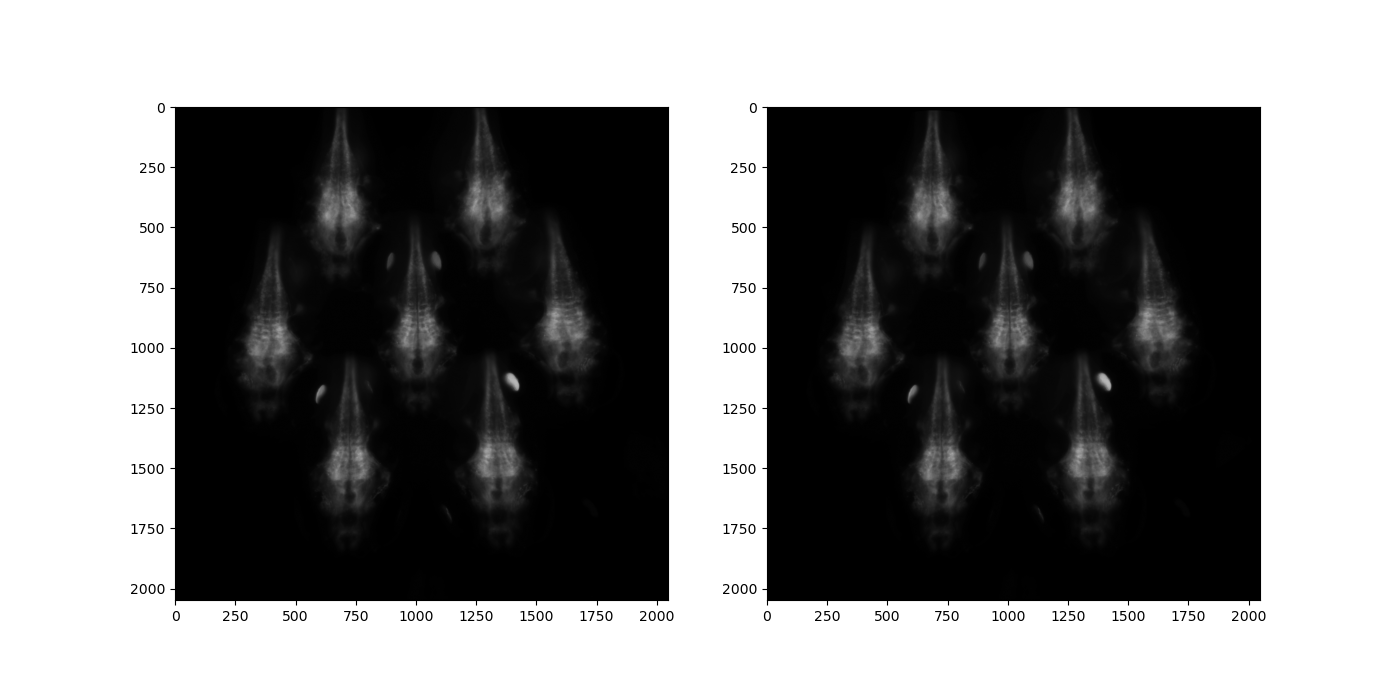

In [8]:
vmax=100
# paths.raw = paths.pn_outrec + "/raw_df.h5"

fig, ax = plt.subplots(1,2,figsize = (14,7))
bg = lazyh5(paths.bg)["data"][crop[0]:crop[1],crop[2]:crop[3]]
with h5py.File(paths.raw, "r") as f:
    ims = np.array(f["data"][225:250,crop[0]:crop[1],crop[2]:crop[3]])
im = ims[0]

ax[0].imshow(im, cmap = "gray",vmax=vmax)
ax[1].imshow((im-bg)*mask, cmap="gray",vmax=vmax)
print(dataset_name)

Generating raw video:   0%|          | 0/11265 [00:00<?, ?it/s]

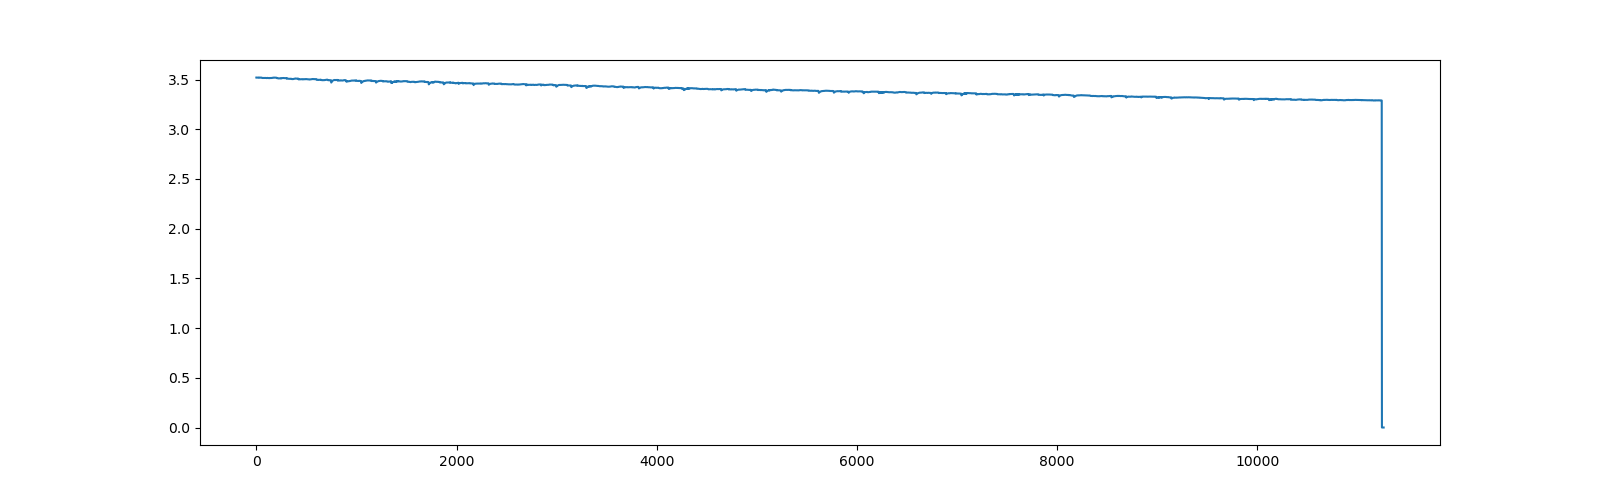

In [73]:
reader = VolumeReader(paths.raw)
means = []
for frame_n, frame in tqdm(reader, desc="Generating raw video"):
    means.append(cp.asarray(frame).flatten().mean().get())
fig, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(means)

(0.0, 100000.0)

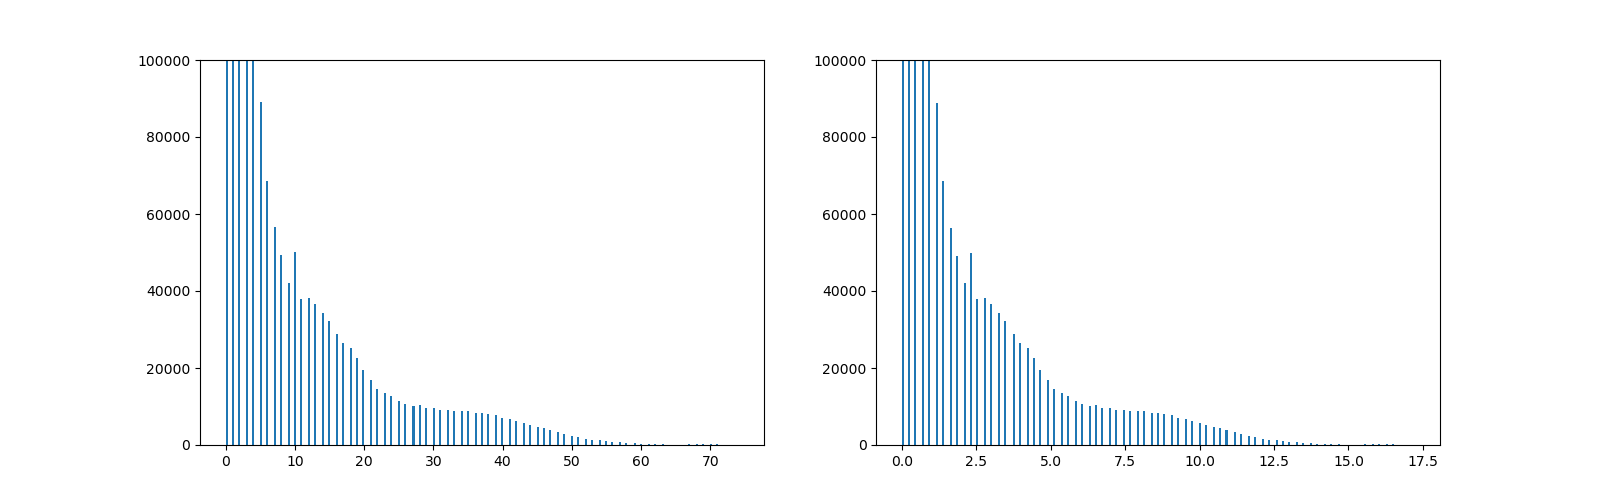

In [65]:
def normalize_mean(arr):
    return arr/arr.mean()
fig, ax = plt.subplots(1,2,figsize = (16,5))
ax[0].hist(im.flatten(),bins=255)
ax[0].set_ylim(0,100000)
ax[1].hist(normalize_mean(((im-bg).clip(0,None)*mask).flatten()),bins=255)
ax[1].set_ylim(0,100000)


In [28]:
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs
img_idx = [325,326,1]
# print(f"PSF zspacing: {np.abs(np.diff(psf["z_positions"][::2])).mean()*1000} um")
objs, mips, losses, kwargs = reconstruct_vols_from_imgs(paths,
                                                        img_idx=img_idx,
                                                        crop = crop,
                                                        max_iter = 30, #if the deconv is to blurry increase, if there is too much noise decrease
                                                        roi_size=550, # if any part of the fish is cut off at teh edge increase this, otherwise decrease this
                                                    
                                                        reuse_prev_vol = False,
                                                        psf_downsample = [40,240,1],
                                                        OTF_normalize=True,
                                                        OTF_clip=False,
                                                        img_subtract_bg=False,
                                                        img_mask=True,
                                                        img_normalize=True,
                                                        plot_decon=True,
                                                        projection="max",
                                                        slice_idx=[35,428,609], #the slice to plot if the projection is "slice"
                                                        vmin=0,
                                                        vmax=4,
                                                        absolute_limits=True)


Loading PSF, Calculating OTF


Calculating OTF: (downsampling PSF by 1):   0%|          | 0/200 [00:00<?, ?it/s]

Reconstructing volumes:   0%|          | 0/1 [00:00<?, ?it/s]

Deconvolving image 1/1:   0%|          | 0/30 [00:00<?, ?it/s]

In [30]:
import video

importlib.reload(video)
from video import array3d_to_video
fn_vid = os.path.join(paths.pn_outrec , f"deconv_mips_{kwargs["vmin"]}-{kwargs["vmax"]}{'_al' if kwargs["absolute_limits"]else''}.mp4")
array3d_to_video(mips[0], fn_vid)
print("test")
play_video_widget(fn_vid)

Creating video:   0%|          | 0/30 [00:00<?, ?it/s]

test


In [31]:
import widgets
importlib.reload(widgets)
from widgets import ortho_views_widget
ortho_views_widget(objs[0], vmin=0, vmax=10, gpu=False)

OrthoViewsWidget(coords=[96, 544, 544], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

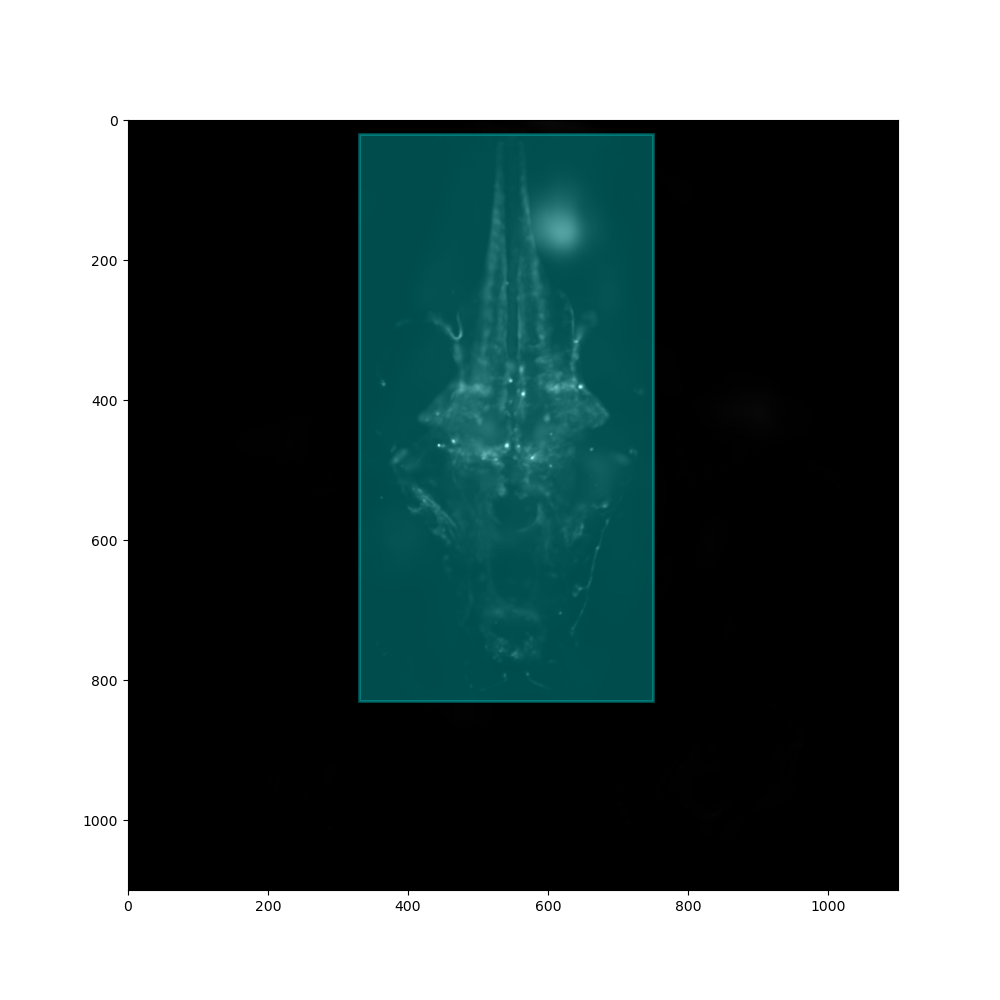

In [33]:
x1, y1 = 330, 20 #top left
x2, y2 = 750, 830 #bottom right
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(objs[0].max(axis=0), cmap = "gray", vmax=4)
rect = plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="cyan", facecolor="cyan", alpha=0.3
    )
ax.add_patch(rect)
out_crop = (y1,y2,x1,x2)
kwargs["out_crop"] = out_crop

In [34]:
kwargs["vmax"] = 4
kwargs["transpose"]=True
kwargs["max_iter"] = 30
kwargs

{'max_iter': 30,
 'xy_pad': 201,
 'roi_size': 550,
 'loss_threshold': 0,
 'reuse_prev_vol': False,
 'psf_downsample': [40, 240, 1],
 'OTF_normalize': True,
 'OTF_clip': False,
 'crop': array([   0, 2048,    0, 2048]),
 'img_subtract_bg': False,
 'img_mask': True,
 'img_normalize': True,
 'fully_batched': False,
 'projection': 'max',
 'slice_idx': [35, 428, 609],
 'vmin': 0,
 'vmax': 4,
 'absolute_limits': True,
 'transpose': True,
 'out_crop': (20, 830, 330, 750)}

## Deconvolve the whole recording

In [41]:
paths.deconvolved = paths.deconvolved[:-3]+"_df2.h5"

In [41]:
import slurm
importlib.reload(slurm)
from slurm import PythonExecutorSLURM
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs_parallel
kwargs, save_fn, vid_fn = reconstruct_vols_from_imgs_parallel(paths,img_idx=None,write_mip_video=True,**kwargs)
# print(save_fn,"\n",vid_fn)


Loading OTF from disk
Setting up I/O queues
Writing into new file: /home/lubo12/hpc-rw/lfm/results/20250828_1713_LB_zf552_para_f1_3/deconvolved.h5


Exception in thread Thread-13 (gpu_worker_loop):
Traceback (most recent call last):
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lubo12/LFM/imaging/reconstruction.py", line 355, in gpu_worker_loop
    worker = GPUWorker(gpu_id, fully_batched=fully_batched)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lubo12/LFM/imaging/reconstruction.py", line 258, in __init__
    self.OTF = cp.asarray(OTF)
               ^^^^^^^^^^^^^^^
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/cupy/_creation/from_data.py", line 88, in asarray
    return _core.array(a, dtype, False, order, blocking=blocking)


KeyboardInterrupt: 

In [35]:
import slurm
importlib.reload(slurm)
from slurm import PythonExecutorSLURM
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs_parallel

email = 'lukas.born@charite.de' 
#cmd_prefix = ['ssh', 'lubo12@s-sc-frontend1'] # if outside HPC (add your user name), otherwise: 
cmd_prefix = [] #if inside HPC
from slurm import PythonExecutorSLURM
slex = PythonExecutorSLURM(job_path=paths.pn_outrec, job_name='deconv'+paths.dataset_name, conda_env='lfm1',
                                     time="1-00:00", partition="pgpu", gres="gpu:4", cpus_per_task=16,mem='128G',ntasks=1,nodes=1,
                                     cmd_prefix=cmd_prefix, mail_user=email, mail_type='ALL,TIME_LIMIT_90')

In [36]:
job_id = slex.submit(reconstruct_vols_from_imgs_parallel, paths, **kwargs, verbose=2)
print(paths.dataset_name)

Submitted batch job 6122578

20250828_1718_LB_zf552_para_f1_4


In [24]:
reg = lazyh5(paths.deconvolved[:-3]+".h5")
kwargs = dict(reg["deconvolution_params"])
# kwargs.pop("OTF")
# kwargs["img_normalize"]=False
# kwargs["vmax"]=0.5
# kwargs["vmin"]=-0.5
kwargs

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/lubo12/hpc-rw/lfm/results/20250828_1718_LB_zf552_para_f1_4/deconvolved.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

1.0005289885506685

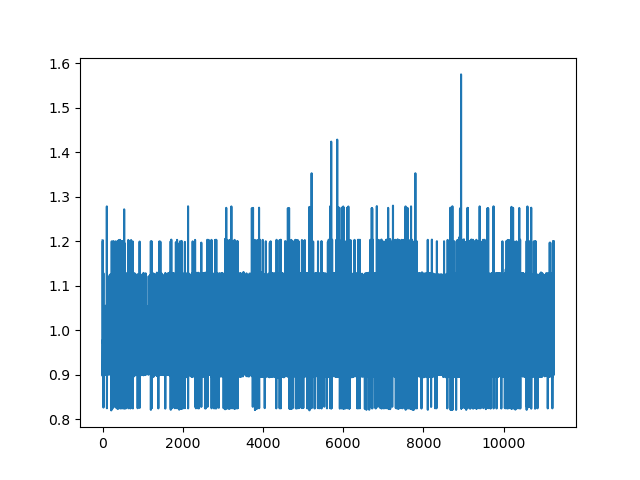

In [45]:
plt.figure()
tstmp = np.array(lazyh5(paths.raw)["tstmp"])
tstmp -= tstmp[~np.isnan(tstmp)].min()
tstmp *= 75
plt.plot(np.diff(tstmp))
np.diff(tstmp[~np.isnan(tstmp)]).mean()

In [37]:
tstmp[~np.isnan(tstmp)].min()

1756834889.269171